In [13]:
%matplotlib inline
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import theano
import seaborn as sns

Optimization terminated successfully.
         Current function value: 3.582379
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 1500/1500 [00:00<00:00, 10859.13it/s]


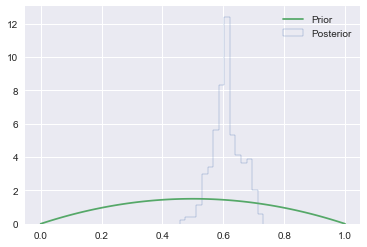

In [14]:
##Coin toss example
#Binomial likelihood, Beta prior
#Number of tosses
n = 100
#Number of times it was heads
h = 61
#Distribution hyperparameters
alpha = 2
beta = 2
#Number of iterations
nIter = 1000
#Context management for pymc3
with pm.Model() as model:
    #Define prior distribution
    p = pm.Beta('p', alpha=alpha, beta=beta)
    #Define likelihood [p(y|theta)] as Binomial(n,p)
    #n = number of Bernoulli trials
    #p = probability of success in each trial
    y = pm.Binomial('y', n=n, p=p, observed=h)
    #Inferencing
    #Find Maximum A Posteriori estimate (via optimization) as the initial state for MCMC
    start = pm.find_MAP()
    #Choose a sampler
    step = pm.Metropolis()
    #Return the trace from the sampling procedure
    trace = pm.sample(nIter, step, start, random_seed=123, progressbar=True)
#Plot the sample extracted from the posterior distribution as a histogram
plt.hist(trace['p'], 15, histtype='step', normed=True, label='Posterior')
#Create array for x-coordinates
x = np.linspace(0, 1, 100)
#Plot a beta distribution B(alpha, beta) representing the prior [p(theta)]
plt.plot(x, stats.beta.pdf(x, alpha, beta), label='Prior')
#Add legend
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 221.761624
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 1500/1500 [00:01<00:00, 891.35it/s]


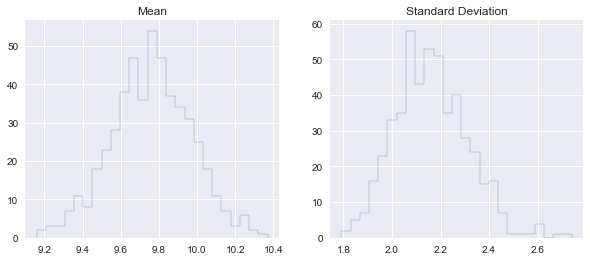

In [18]:
##Estimating mean and stdev of normal distribution
#Number of samples
N = 100
#Normal distribution mean
_mu = np.array([10])
#Normal distribution standard deviation
_sigma = np.array([2])
#N samples from the normal distribution with mean _mu and stdev _sigma
y = np.random.normal(_mu, _sigma, N)

nIter = 1000

with pm.Model() as model:
    #Define prior distribution's mean and standard deviation as sampled from a uniform distribution
    mu = pm.Uniform('mu', lower=0, upper=100, shape=_mu.shape)
    sigma = pm.Uniform('sigma', lower=0, upper=10, shape=_sigma.shape)
    #Define likelihood from a normal distribution based on mu and sigma
    #The observed argument indicates that the values were observed, and should not be changed by any fitting algorithm
    y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=y)

    #Inferencing procedure to determine posterior samples
    start = pm.find_MAP()
    step = pm.Slice()
    trace = pm.sample(nIter, step, start, random_seed=123, progressbar=True)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
#Plot histogram of the latter half of posterior mu
#Latter half are selected due to sampling burn-in (not reaching convergence)
plt.hist(trace['mu'][int(-nIter/2):,0], 25, histtype='step')
plt.title('Mean')
plt.subplot(1,2,2)
#Plot histogram of the latter half of posterior sigma
plt.hist(trace['sigma'][int(-nIter/2):,0], 25, histtype='step')
plt.title('Standard Deviation')
plt.show()

Optimization terminated successfully.
         Current function value: 28.063663
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 1500/1500 [00:01<00:00, 858.05it/s]


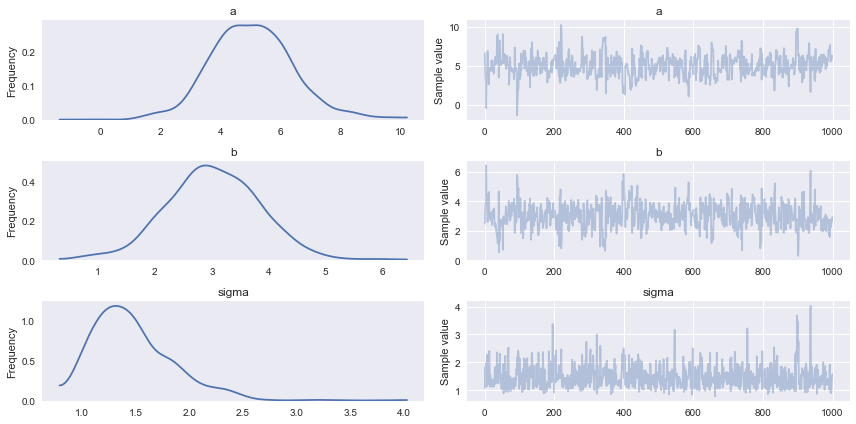

In [20]:
##Estimating parameters of a linear regression model
# y ~ ax + b
# y = ax + b + e
# y ~ N(ax + b, sigma^2)
#Assume priors (t = precision = 1 / sigma^2):
#a ~ N(0, 100)
#b ~ N(0, 100)
#t ~ Gamma(0.1, 0.1)
#Number of Iterations
nIter = 1000
#Observed dat
#Number of observations
n = 11
#Coefficients
_a = 6
_b = 2
#Uniform distribution of x
x = np.linspace(0, 1, n)
#Linear model (including random error) with n observations
y = _a*x + _b + np.random.randn(n)
with pm.Model() as model:
    #Determine distributions from which to sample the coefficients
    a = pm.Normal('a', mu=0, sd=20)
    b = pm.Normal('b', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    #Estimate mean of likelihood
    y_est = a*x + b
    #Likelihood
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    #Inference
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(nIter, step, start, random_seed=123, progressbar=True)
    #Plot traceplot for a, b, and stdev
    pm.traceplot(trace)
plt.show()

100%|██████████| 2500/2500 [00:03<00:00, 659.75it/s]


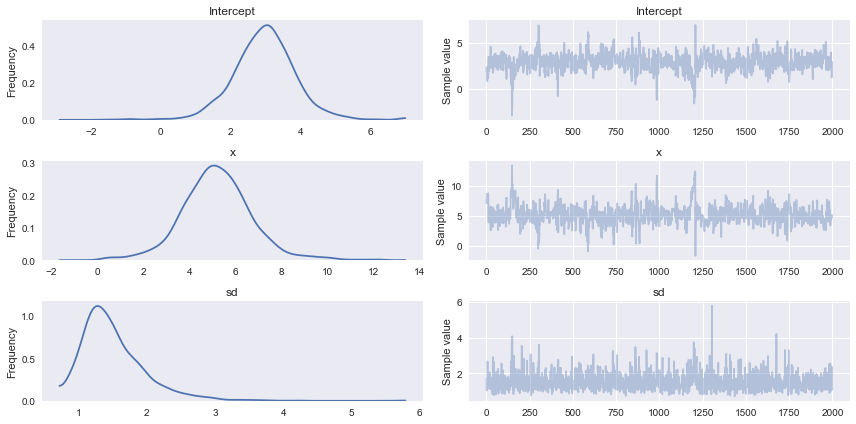

In [21]:
#Alternative formulation using General Linear Models
data = dict(x=x, y=y)
with pm.Model() as model:
    #Coefficients are fixed
    pm.glm.GLM.from_formula('y ~ x', data)
    step = pm.NUTS()
    trace = pm.sample(2000, step, progressbar=True)
    pm.traceplot(trace)
plt.show()

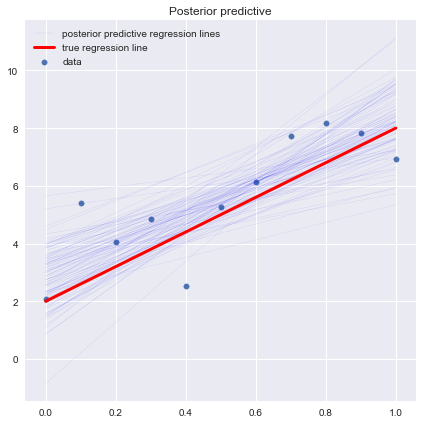

In [22]:
#Plot regression line and datapoints
plt.figure(figsize=(7, 7))
plt.scatter(x, y, s=30, label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,
                                 label='posterior predictive regression lines',
                                 c='blue', alpha=0.2)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best')
plt.show()
#Fit is skewed due to low levell of mass in the tails of the normal distribution
#An outlier affects the fit strongly

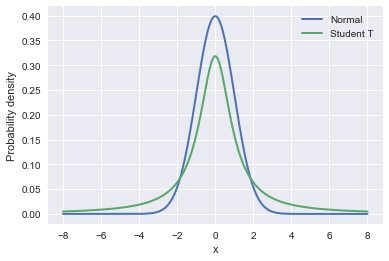

In [23]:
#We can assume that the data is not normally distributed, but distributed according to Student T distribution
#Comparing the two distributions
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.figure()
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
INFO:pymc3:Initializing NUTS using ADVI...
Average Loss = 29.508:   9%|▊         | 17192/200000 [00:01<00:17, 10380.61it/s]
Convergence archived at 17200
INFO:pymc3.variational.inference:Convergence archived at 17200
Interrupted at 17,200 [8%]: Average Loss = 38.228
INFO:pymc3.variational.inference:Interrupted at 17,200 [8%]: Average Loss = 38.228
100%|██████████| 2500/2500 [00:03<00:00, 688.94it/s]


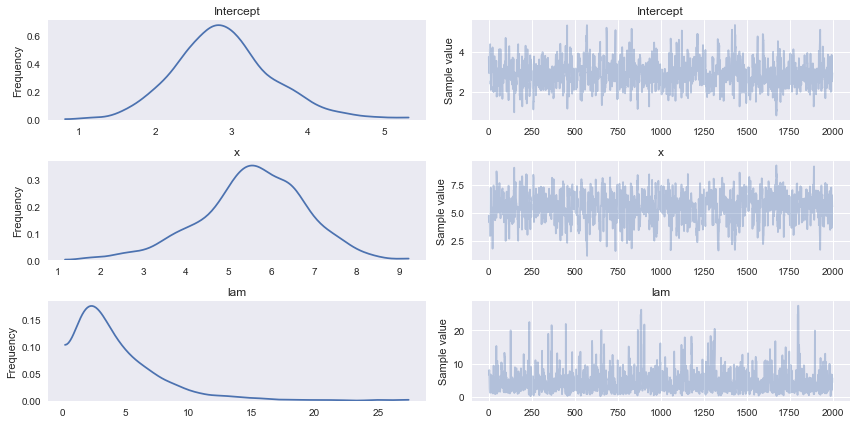

In [24]:
#Testing the model with a student T from the families object
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(2000)
    pm.traceplot(trace_robust)
plt.show()

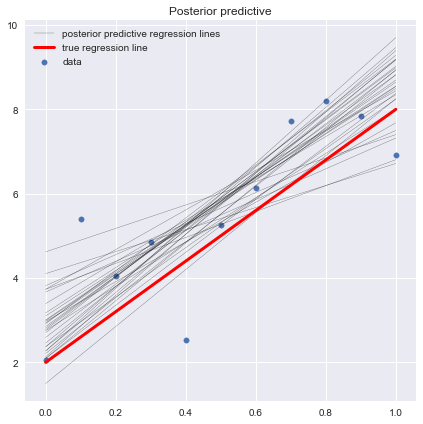

In [25]:
#Plotting the model specifying our data is spread according to a student T distribution
plt.figure(figsize=(7, 7))
plt.scatter(x, y, s=30, label='data')
pm.plot_posterior_predictive_glm(trace_robust,
                                 label='posterior predictive regression lines')
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend()

100%|██████████| 2500/2500 [00:04<00:00, 557.56it/s]


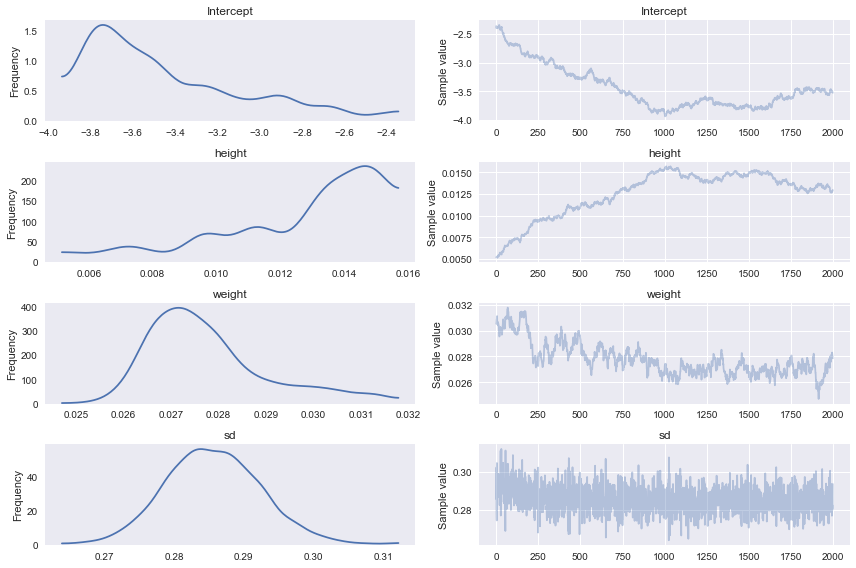

In [35]:
#Read pandas dataset with sex, heights, and weights
df = pd.read_csv('J:\Source\BayesApplications\FakeHeight.csv')
#Number of iterations
nIter = 2000
with pm.Model() as model:
    #Is a person a male based on height + weight, assuming that the data is distributed according to a Binomial
    pm.glm.GLM.from_formula('male ~ height + weight', df)
    #Height and Weight's coefficients are now traced
    trace = pm.sample(nIter, step=pm.Slice(), random_seed=123, progressbar=True)
    pm.traceplot(trace)

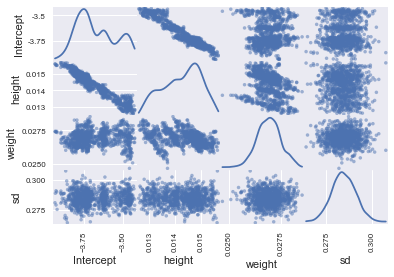

In [36]:
#Plot scatter matrix between intercept, height and weight
df_trace = pm.trace_to_dataframe(trace)
pd.plotting.scatter_matrix(df_trace[-1000:], diagonal='kde')
plt.show()

J:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


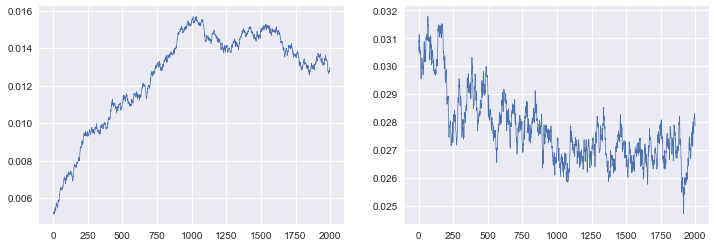

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(df_trace.ix[-1000:, 'height'], linewidth=0.7)
plt.subplot(122)
plt.plot(df_trace.ix[-1000:, 'weight'], linewidth=0.7)
plt.show()

In [38]:
pm.summary(trace)
#As a conclusion, when height's coefficient decreases, weight's coefficient increases
#Plots suggest a strong correlation between the 2 variables


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -3.437           0.368            0.037            [-3.874, -2.672]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -3.851         -3.732         -3.544         -3.221         -2.559


height:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.013            0.003            0.000            [0.007, 0.016]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.006          0.011          0.013          0.015          0.015


weight:

  Mean             SD               MC Error         95% HPD interval
  ----------------

100%|█████████▉| 2499/2500 [06:18<00:00,  5.07it/s]J:\Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
J:\Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.88341471104, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [06:18<00:00,  6.61it/s]
J:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


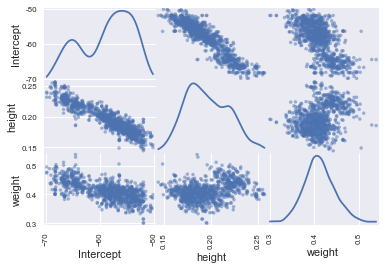

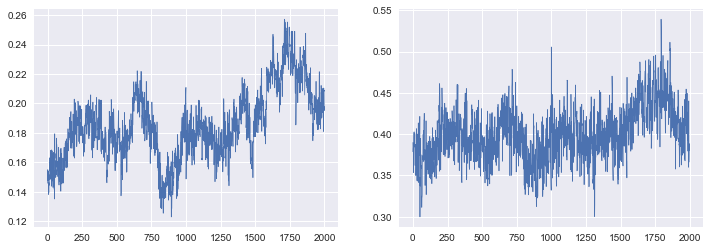


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -56.172          5.097            0.501            [-67.047, -47.220]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -67.027        -58.770        -55.710        -52.971        -47.038


height:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.185            0.024            0.002            [0.140, 0.232]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.142          0.170          0.183          0.201          0.236


weight:

  Mean             SD               MC Error         95% HPD interval
  -------------

In [39]:
#Attempting the same results with a different sampler
with pm.Model() as model:
    pm.glm.GLM.from_formula('male ~ height + weight', df, family=pm.glm.families.Binomial())
    trace = pm.sample(nIter, step=pm.NUTS(), random_seed=123, progressbar=True)
    pm.traceplot(trace)
df_trace = pm.trace_to_dataframe(trace)
pd.plotting.scatter_matrix(df_trace[-1000:], diagonal='kde')
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(df_trace.ix[-1000:, 'height'], linewidth=0.7)
plt.subplot(122)
plt.plot(df_trace.ix[-1000:, 'weight'], linewidth=0.7)
plt.show()
pm.summary(trace)

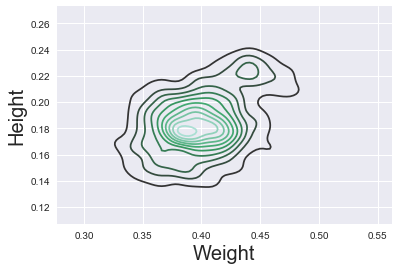

In [40]:
#KDE plot in seaborn
plt.figure()
sns.kdeplot(trace['weight'], trace['height'])
plt.xlabel('Weight', fontsize=20)
plt.ylabel('Height', fontsize=20)
plt.style.use('ggplot')
plt.show()

In [50]:
#Select intercept, height, weight means from the latter half of the trace
intercept, height, weight = df_trace[-nIter // 2:].mean(0)
def predict(w, h, height=height, weight=weight):
    #Predict gender given weight (w) and height (h) values
    v = intercept + height * h + weight * w
    return np.exp(v) / (1 + np.exp(v))

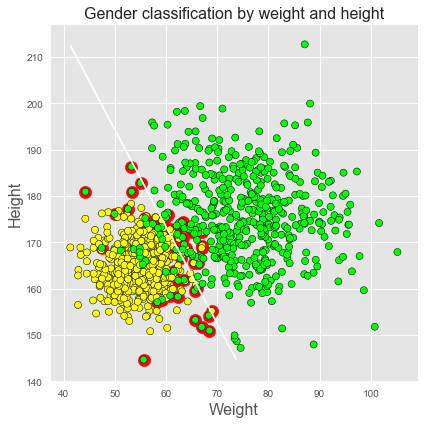

In [51]:
#Calculate predictions on grid
#Define uniform weights
xs = np.linspace(df.weight.min(), df.weight.max(), 100)
#Define uniform heights
ys = np.linspace(df.height.min(), df.height.max(), 100)
#Merge the 2 arrays
X, Y = np.meshgrid(xs, ys)
#Predict gender where X = weight, Y = height
Z = predict(X, Y)
plt.figure(figsize=(6, 6))
#Plot 0.5 contour line - classify as male if above this line
plt.contour(X, Y, Z, levels=[0.5])
#Classify all subjects
colors = ['lime' if i else 'yellow' for i in df.male]
#Create predictions on existing data
ps = predict(df.weight, df.height)
#Create errors
errs = ((ps < 0.5) & df.male) | ((ps >= 0.5) & (1 - df.male))
#Plot error circles
plt.scatter(df.weight[errs], df.height[errs], facecolors='red', s=150)
#Plot data points
plt.scatter(df.weight, df.height, facecolors=colors, edgecolors='k', s=50, alpha=1)
plt.xlabel('Weight', fontsize=16)
plt.ylabel('Height', fontsize=16)
plt.title('Gender classification by weight and height', fontsize=16)
plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 7.987117
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


 92%|█████████▏| 1379/1500 [00:01<00:00, 1352.84it/s]J:\Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:456: UserWarning: Chain 0 contains 10 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:01<00:00, 1359.58it/s]



alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.027            0.924            0.038            [-0.539, 2.999]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.661         0.391          0.978          1.605          2.951


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.491            3.869            0.237            [2.461, 16.577]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.150          6.467          9.153          12.207         18.277



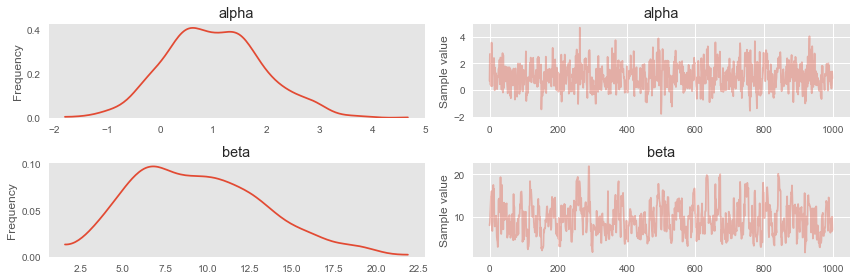

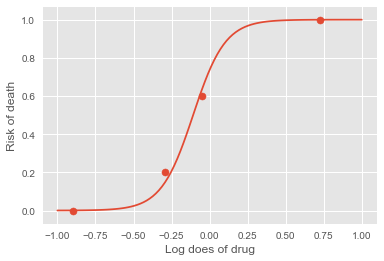

In [52]:
#Estimating parameters of a logistic model (example from Gelman et al.)
#Model where dose of a drug may be affect the number of rat deaths in an experiment
#Model number of deaths as a random sample from a binomial distribution, n = no. of rats, p = probability of death
#n = 5, but p may be related to drug dose x
#As x increases, the number of dying rats seems to increase
#y ~ Binomial (n, p)
#logit(p) = a + bx
#a ~ N(0, 5)
#b ~ N(0, 10)
#a and b have vague priors (as parameters for the model)
nIter = 1000
#Observed data
n = 5 * np.ones(4)
x = np.array([-0.896, -0.296, -0.053, 0.727])
y = np.array([0, 1, 3, 5])
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))
with pm.Model() as model:
    #Define priors
    alpha = pm.Normal('alpha', mu=0, sd=5)
    #beta = pm.Flat('beta')
    beta = pm.Normal('beta', mu=0, sd=10)
    #Define likelihood [p(y|theta)] as Binomial(n,p)
    #n = number of trials
    #p = probability of success in each trial
    p = invlogit(alpha + beta*x)
    y_obs = pm.Binomial('y_obs', n=n, p=p, observed=y)
    #Inference
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(nIter, step, start, random_seed=123, progressbar=True)
    pm.traceplot(trace)
pm.summary(trace)
f = lambda a, b, xp: np.exp(a + b * xp) / (1 + np.exp(a + b * xp))
xp = np.linspace(-1, 1, 100)
a = trace.get_values('alpha').mean()
b = trace.get_values('beta').mean()
plt.figure()
plt.plot(xp, f(a, b, xp))
plt.scatter(x, y / 5, s=50)
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death')
plt.show()

         Current function value: -632.566354
         Iterations: 493
         Function evaluations: 798
         Gradient evaluations: 786


100%|██████████| 2500/2500 [07:32<00:00,  4.80it/s]J:\Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)




mu_a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.465            0.046            0.004            [1.375, 1.548]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.378          1.432          1.465          1.498          1.552


mu_b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.524           0.000            0.000            [-0.524, -0.523]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.524         -0.524         -0.524         -0.524         -0.523


slope:

  Mean             SD               MC Error         95% HPD interval
  ------------------------


intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0.524           0.000            0.000            [-0.524, -0.523]
  -0


sigma_a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.313            0.043            0.003            [0.238, 0.405]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.238          0.284          0.312          0.341          0.405


sigma_b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.000          0.000


sigma:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

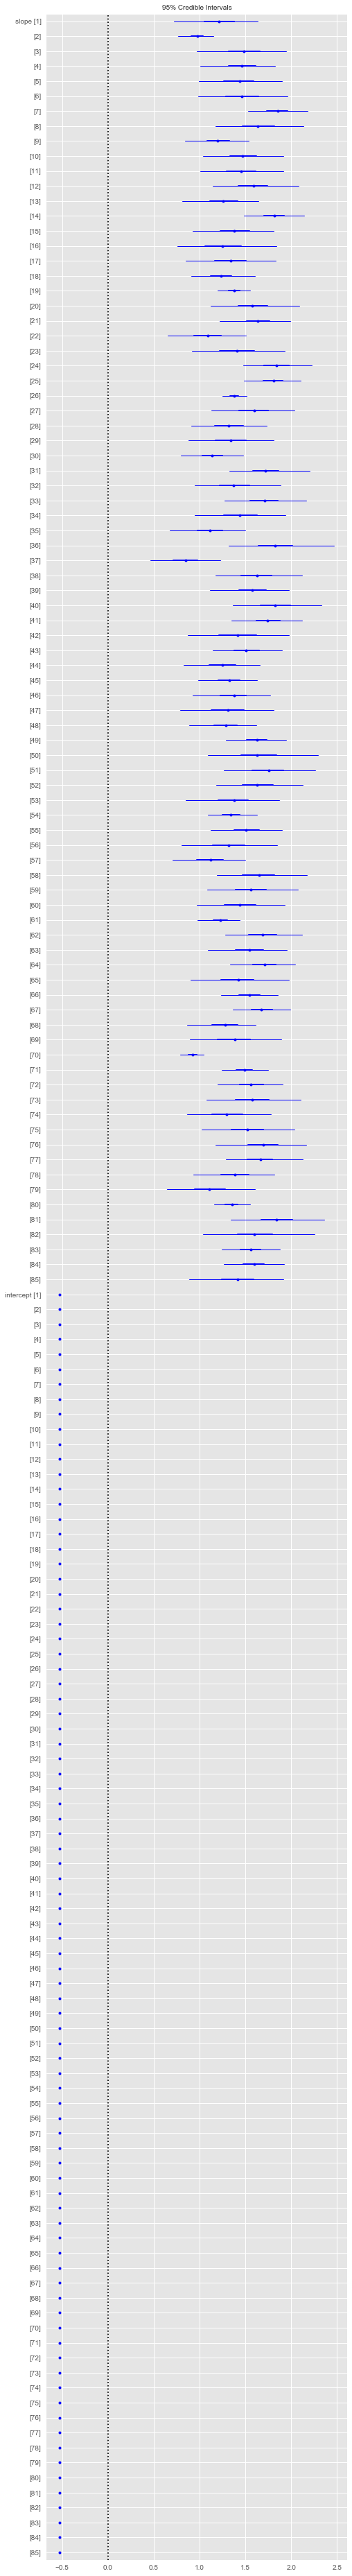

In [55]:
#Using a hierarchical model based on Radon data set
radon = pd.read_csv('J:\Source\BayesApplications\Radon.csv')[['county', 'floor', 'log_radon']]
radon.dropna(inplace=True)

#With a hierarchical model, there is an ac and bc for each county c just as an individual county model ac*x + b = y
#They are no longer independent but assume to come from a common group distribution
#ac ~ N(mua, sda^2)
#bc ~ N(mub, sdb^2)
#Further assumptions for the hyperparameters
#mua ~ N(0, 100^2)
#sda ~ U(0, 100)
#mub ~ N(0, 100^2)
#sdb ~ U(0, 100)

#Transform counties into codes
county = pd.Categorical(radon['county']).codes

with pm.Model() as hm:
    #County hyperparameters
    mu_a = pm.Normal('mu_a', mu=0, tau=1.0/100**2)
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=100)
    mu_b = pm.Normal('mu_b', mu=0, tau=1.0/100 ** 2)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)

    #County slope and intercept - can either provide sd or tau
    a = pm.Normal('slope', mu=mu_a, sd=sigma_a, shape=len(set(county)))
    b = pm.Normal('intercept', mu=mu_b,  tau = 1.0/sigma_b**2, shape=len(set(county)))

    #Household errors - following gamma distribution
    sigma = pm.Gamma('sigma', alpha=10, beta=1)

    #Model prediction of radon level based on county distribution of floor levels
    mu = a[county] + b[county] * radon.floor.values

    #Likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=radon.log_radon)

with hm:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    hm_trace = pm.sample(2000, step, start=start, random_seed=123, progressbar=True)

pm.summary(hm_trace)

plt.figure(figsize=(8, 60))
pm.forestplot(hm_trace, varnames=['slope', 'intercept'])


plt.show()